In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import lightning as L

from solvers.dpt.train import DPTSolver
from problems import Net
from dpt_run import get_online_dataloader, load_config
from utils import print_trajectory

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# from problems import Net
# from utils import *

# problem = Net(d=4, n=2, seed=0)
# all_actions = get_xaxis(d=problem.d, n=problem.n)
# all_states = problem.target(all_actions)
# print(np.array([all_states.max()]).shape)
# print(np.empty(shape=(1)).shape)

In [4]:
# logits = torch.randn(size=(1, 10))
# # plt.plot(logits[0])

# for t in (0.01, 0.5, 1.0, 1.5, 2.0, 5.0, 100.0):
#     probs_t = torch.nn.functional.softmax(logits / t, dim=-1)
#     plt.plot(probs_t[0], label=t)

# plt.legend()
# plt.show()

In [3]:
config = load_config('config.yaml')

d = int(np.log2(config["model_params"]["num_actions"]))
problems = [Net(d=d, n=2, seed=i) for i in range(271, 281)]
val_online_dataloader = get_online_dataloader(problems, config)
print('val_online_dataloader:', len(val_online_dataloader.dataset))

val_online_dataloader: 10


In [4]:
checkpoint_file = '../GreyBoxDPTOptimizerData/GreyBoxDPTOptimizer/0cxrd4bf/checkpoints/epoch=299-step=9600.ckpt'
model = DPTSolver.load_from_checkpoint(checkpoint_file).to(device)
model.eval()
print()

In [5]:
import matplotlib.pyplot as plt

In [14]:
def check_temperature(temperature_function):
    visited_points = []
    convergency_step = []

    for _ in range(10):
        for batch in val_online_dataloader:
            for sample in batch:
                result = model.run(
                    **sample,
                    n_steps=config["model_params"]["seq_len"],
                    return_trajectory=True,
                    temperature_function=temperature_function
                )
                right_action_indexes = torch.where(result["actions"] == sample["target_action"])[0]
                if len(right_action_indexes):
                    right_action_step = right_action_indexes[0].item() + 1
                    visited_points_number = len(torch.unique(result["actions"][:right_action_step]))
                else:
                    right_action_step = np.nan
                    visited_points_number = np.nan
                convergency_step.append(right_action_step)
                visited_points.append(visited_points_number)
            # print(model._online_step(batch, 0))
            # break
    mask = np.isnan(convergency_step)
    if mask.all():
        convergency_step = np.nan
        visited_points = np.nan
    else:
        convergency_step = np.nanmean(convergency_step)
        visited_points = np.nanmean(visited_points)
    return convergency_step, visited_points, mask

In [15]:
temperature_results = {}
temperature_functions = {
   'argmax': lambda x: 0,
    't = 0.00001': lambda x: 0.00001,
    't = 0.5': lambda x: 0.5,
    't = 1.0': lambda x: 1.0, 
    't = 10':  lambda x: 10,
    't = 100': lambda x: 100,
    't ~ 1 - n_step / n_steps': lambda x: 1 - x / config["model_params"]["seq_len"],
    't ~ 10 * (1 - n_step / n_steps)': lambda x: 10 * (1 - x / config["model_params"]["seq_len"]),
    't ~ 100 * (1 - n_step / n_steps)': lambda x: 100 * (1 - x / config["model_params"]["seq_len"]) 
}
for name, temperature_function in temperature_functions.items():
   convergency_step, visited_points, mask = check_temperature(temperature_function)
   temperature_results[name] = dict(
      convergency_step=convergency_step, 
      visited_points=visited_points, 
      mask=mask,
      temperature_function=temperature_function
    ) 

Temperature function: argmax
Converged at 1.7/50 step in 9/100 cases and visited 1.6/16 points

Temperature function: t = 0.00001
Converged at 1.4/50 step in 5/100 cases and visited 1.4/16 points

Temperature function: t = 0.5
Converged at 2.2/50 step in 9/100 cases and visited 2.0/16 points

Temperature function: t = 1.0
Converged at 1.8/50 step in 8/100 cases and visited 1.8/16 points

Temperature function: t = 10
Converged at 11.1/50 step in 99/100 cases and visited 6.6/16 points

Temperature function: t = 100
Converged at 13.6/50 step in 100/100 cases and visited 8.1/16 points

Temperature function: t ~ 1 - n_step / n_steps
Converged at 3.2/50 step in 5/100 cases and visited 2.4/16 points

Temperature function: t ~ 10 * (1 - n_step / n_steps)
Converged at 11.3/50 step in 87/100 cases and visited 6.9/16 points

Temperature function: t ~ 100 * (1 - n_step / n_steps)
Converged at 14.7/50 step in 100/100 cases and visited 8.2/16 points



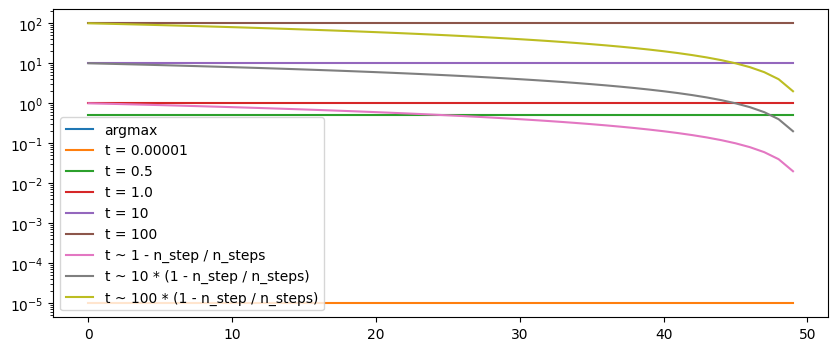

In [16]:
seq_len = config["model_params"]["seq_len"]
n_step_range = np.arange(0, seq_len)
num_actions = config["model_params"]["num_actions"]

plt.figure(figsize=(10, 4))
for name, result in temperature_results.items():
    print(f'Temperature function: {name}')
    if result['mask'].all():
        print('Has not converged')
    else:
        s_1 = f'Converged at {result["convergency_step"]:.1f}/{seq_len} step'
        s_2 = f' in {np.sum(~result["mask"])}/{len(result["mask"])} cases'
        s_3 = f' and visited {result["visited_points"]:.1f}/{num_actions} points'
        print(s_1 + s_2 + s_3)
    print()
    plt.plot(n_step_range, [result["temperature_function"](n_step) for n_step in n_step_range], label=name)

plt.hlines(0, n_step_range[0], n_step_range[-1])
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
# print_trajectory(result, problems[0])

In [ ]:
# trainer = L.Trainer(
#     precision=config["precision"],
#     enable_model_summary=False
# )
# trainer.test(model, dataloaders=val_online_dataloader)

In [ ]:
# checkpoint = torch.load(checkpoint_file)
# print(checkpoint['hyper_parameters'])